Installing the necessary libraries. (this might be not necessary if requirements.txt is included)

In [1]:
!pip install fastai duckduckgo_search

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.3 MB 3.3 MB/s eta 0:00:01
   --------- ------------------------------ 0.6/2.3 MB 7.0 MB/s eta 0:00:01
   ------------------------ --------------- 1.4/2.3 MB 11.1 MB/s eta 0:00:01
   -------------------------------------- - 2.2/2.3 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 12.3 MB/s eta 0:00:00


## Step 1: Download images of birds and non-birds

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
#     return L(ddg_images(term, max_results=max_images)).itemgot('image')
    return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

...and then download a URL and take a look at it:

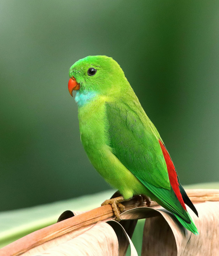

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


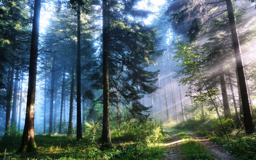

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [6]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model¶

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

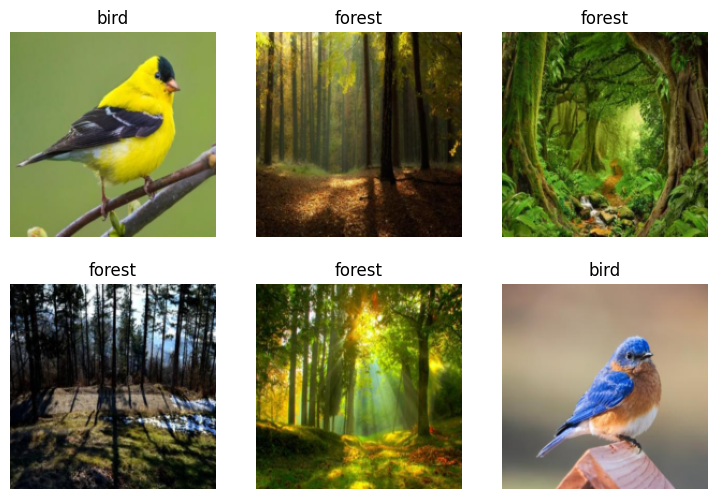

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    # Inputs for our model are images, outputs are categories (bird or forest)
    get_items=get_image_files, 
    # Returns a list of all images in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Split the data into training and validation sets, using 20% for validation
    get_y=parent_label,
    # The label for each image is the name of the folder it's in
    item_tfms=[Resize(192, method='squish')]
    # Resize each image to 192x192 pixels by squishing instead of cropping
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
# Create a model using the data in `dls`, using the ResNet18 architecture
learn.fine_tune(3)
# Fine-tune the model for 3 epochs

epoch,train_loss,valid_loss,error_rate,time
0,1.198165,0.766516,0.264706,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.170871,0.135665,0.029412,00:00
1,0.129161,0.014403,0.000000,00:00
2,0.094880,0.023161,0.000000,00:00


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories)

In [10]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including creating amazing artworks, and explaining jokes. It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!